## Load needed modules and define path to data

In [1]:
on_aws = False

In [2]:
#for speech to text
import speech_recognition as sr

In [3]:
#for pyannote-audio's diarisation
import torch
from huggingface_hub import HfApi
available_pipelines = [p.modelId for p in HfApi().list_models(filter="pyannote-audio-pipeline")]
available_pipelines

['pyannote/speaker-diarization',
 'pyannote/overlapped-speech-detection',
 'pyannote/voice-activity-detection',
 'pyannote/speaker-segmentation']

In [4]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

## List Files in Tarxya Bucket

In [5]:
if on_aws:
    !aws s3 ls voicetarxya/purchased/

## Specify the file and desired time window

In [7]:
if on_aws:
    print("ON AWS!")
    !aws s3 cp s3://voicetarxya/purchased/in-443303309465-07449988008-20190624-110909-1561370949.138008.wav test_audio_from_s3.wav
    #!aws s3 cp s3://voicetarxya/purchased/q-801-1562945353.213997.wav test_audio_from_s3.wav
    !ls *wav
    base = "test_audio_from_s3" 
    audio = base + ".wav" 
    GLOBAL_START = 0. 
    GLOBAL_END = 60. 
if not on_aws:
    print("NOT ON AWS!")
    !ls *wav
    base = "audio" 
    audio = base + ".wav"
    GLOBAL_START = 480.
    GLOBAL_END = 540.

NOT ON AWS!
audio.wav


## Speech to text on specified time segment

In [8]:
r = sr.Recognizer()
audio_sr = sr.AudioFile(audio)



In [9]:
with audio_sr as source:
    audiodata = r.record(source, offset=GLOBAL_START, duration = GLOBAL_END-GLOBAL_START)
try:
    print(r.recognize_google(audiodata,language="en-GB"))
except Exception as e:
    print("Error : " + str(e))

cheers yeah none of it comes back out to me it's a limited company and it just says the third one is there are four of us it's a mental health trust yeah and the money just goes into pay the employees salary I don't take anything from it no could I know no sure ok so that I don't want to take it and then got someone goes all that wasn't are no woman no no no what I'm going to do is I'll basically what you said he's going to ring up 84 UK and clarify that with them so I think it's important to so first one is it's open but there's nothing going in and it's not trading or non-trading ok the second one is cash in but it goes automatically so that's holiday lettings and it automatically just get it it's in the business it's a limited


# WARNING THE NEXT CELL IS SLOW TO RUN, DONT RUN UNLESS NEED!
## this performs the diarisation on the entire audio file, it takes a while to run

In [12]:
# diarization
dia = pipeline(audio)

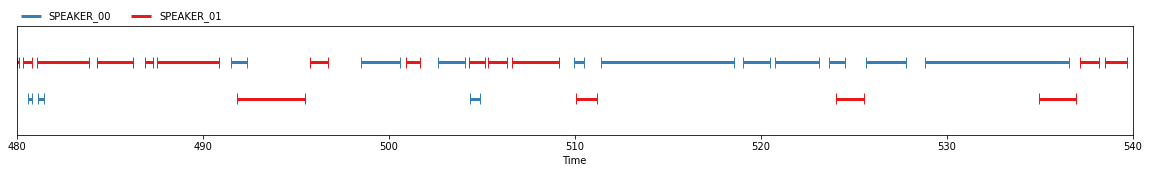

In [13]:
# plot whole dia
dia

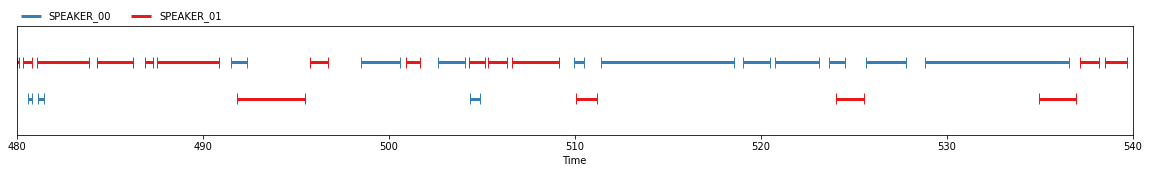

In [14]:
# crop time interval and replot
from pyannote.core import notebook, Segment
notebook.crop = Segment(GLOBAL_START, GLOBAL_END)
dia

## Print out resulting time buckets of diarisation within desired time section
## Visualise the output 

In [15]:
for turn, _, speaker in dia.itertracks(yield_label=True):
    if (turn.start > GLOBAL_START and turn.start < GLOBAL_END):
        print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=480.3s stop=480.8s speaker_SPEAKER_01
start=480.6s stop=480.8s speaker_SPEAKER_00
start=481.1s stop=483.9s speaker_SPEAKER_01
start=481.1s stop=481.5s speaker_SPEAKER_00
start=484.3s stop=486.3s speaker_SPEAKER_01
start=486.9s stop=487.3s speaker_SPEAKER_01
start=487.5s stop=490.9s speaker_SPEAKER_01
start=491.5s stop=492.4s speaker_SPEAKER_00
start=491.8s stop=495.5s speaker_SPEAKER_01
start=495.8s stop=496.7s speaker_SPEAKER_01
start=498.5s stop=500.6s speaker_SPEAKER_00
start=501.0s stop=501.7s speaker_SPEAKER_01
start=502.6s stop=504.1s speaker_SPEAKER_00
start=504.3s stop=505.2s speaker_SPEAKER_01
start=504.4s stop=504.9s speaker_SPEAKER_00
start=505.4s stop=506.4s speaker_SPEAKER_01
start=506.7s stop=509.2s speaker_SPEAKER_01
start=510.0s stop=510.5s speaker_SPEAKER_00
start=510.1s stop=511.2s speaker_SPEAKER_01
start=511.4s stop=518.6s speaker_SPEAKER_00
start=519.0s stop=520.5s speaker_SPEAKER_00
start=520.8s stop=523.1s speaker_SPEAKER_00
start=523.7s stop=524.5s speaker

## Speech recognition on the above diarisation time bins and output with labelled speakers

In [16]:
r = sr.Recognizer()
audio_sr = sr.AudioFile(audio)
!ls *wav

audio.wav


In [17]:
for turn, _, speaker in dia.itertracks(yield_label=True):
    start_time = turn.start
    end_time = turn.end
    if (turn.start > GLOBAL_START and turn.start < GLOBAL_END):
        with audio_sr as source:
            audiodata = r.record(source, offset=start_time-0.1, duration = end_time-start_time+0.1)
        try:
            words = r.recognize_google(audiodata,language="en-GB")
            #print(f"*------------------------START---------t={turn.start:.1f}s--------*")
            print(f"{speaker} : {words}")
            print("")
            #print(f"*-------------------------END----------t={turn.end:.1f}s--------*")
        except Exception as e:
            print(f"{speaker} : ???")
            print("")
        

SPEAKER_01 : ???

SPEAKER_00 : ???

SPEAKER_01 : none of it comes back out to me it's a

SPEAKER_00 : ???

SPEAKER_01 : and it just stays there

SPEAKER_01 : ???

SPEAKER_01 : there were four of us it's a mental

SPEAKER_00 : ???

SPEAKER_01 : yeah and the manor just goes in to pay the employees

SPEAKER_01 : anything

SPEAKER_00 : ???

SPEAKER_01 : ???

SPEAKER_00 : no no sure

SPEAKER_01 : ???

SPEAKER_00 : ???

SPEAKER_01 : ???

SPEAKER_01 : take it and then go and someone goes all that

SPEAKER_00 : ???

SPEAKER_01 : no

SPEAKER_00 : no no no what I'm going to do is I'll basically what you said it's going to ring up 8 for UK and clarify that with them so I think it's in

SPEAKER_00 : first one

SPEAKER_00 : is it open but there's no

SPEAKER_00 : ???

SPEAKER_01 : and now it's not

SPEAKER_00 : oh no not trading

SPEAKER_00 : the second one is cash in but it goes automatically so that's holiday lettings and it automatically just get those

SPEAKER_01 : actually just get

SPEAKER_01

## My attempt at stitching audio pieces together

##### idea here is that sometimes continuous speach by one speaker is broken into multiple chunks here, one long chunk is better for speech to text

In [18]:
# list each bin output from diariazation, some adjacent bins have the same speaker

speech_fragments = []
for turn, track, speaker in dia.itertracks(yield_label=True):
    if (turn.end > GLOBAL_START and turn.start < GLOBAL_END):
        speech_fragments += [[speaker,turn.start,turn.end,"new"]]
        print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")
#for i in range(len(speech_fragments)): print(speech_fragments[i])

start=477.4s stop=480.1s speaker_SPEAKER_01
start=480.3s stop=480.8s speaker_SPEAKER_01
start=480.6s stop=480.8s speaker_SPEAKER_00
start=481.1s stop=483.9s speaker_SPEAKER_01
start=481.1s stop=481.5s speaker_SPEAKER_00
start=484.3s stop=486.3s speaker_SPEAKER_01
start=486.9s stop=487.3s speaker_SPEAKER_01
start=487.5s stop=490.9s speaker_SPEAKER_01
start=491.5s stop=492.4s speaker_SPEAKER_00
start=491.8s stop=495.5s speaker_SPEAKER_01
start=495.8s stop=496.7s speaker_SPEAKER_01
start=498.5s stop=500.6s speaker_SPEAKER_00
start=501.0s stop=501.7s speaker_SPEAKER_01
start=502.6s stop=504.1s speaker_SPEAKER_00
start=504.3s stop=505.2s speaker_SPEAKER_01
start=504.4s stop=504.9s speaker_SPEAKER_00
start=505.4s stop=506.4s speaker_SPEAKER_01
start=506.7s stop=509.2s speaker_SPEAKER_01
start=510.0s stop=510.5s speaker_SPEAKER_00
start=510.1s stop=511.2s speaker_SPEAKER_01
start=511.4s stop=518.6s speaker_SPEAKER_00
start=519.0s stop=520.5s speaker_SPEAKER_00
start=520.8s stop=523.1s speaker

In [19]:
# label if speaker is new or repeated and 
# make the "new" buckets have start and end times that absorb the later buckets with same speaker

# the reverse loop is important as we want to pull the latest finish time to the first start time

for i in reversed(range(len(speech_fragments)-1)): 
    frag = speech_fragments[i]
    nextfrag = speech_fragments[i+1]
    if frag[0]==nextfrag[0]:
        nextfrag[1] = frag[1]
        frag[2]=nextfrag[2]
        nextfrag[3] = "repeat"
    
for frag in speech_fragments: print(frag)
        


['SPEAKER_01', 477.43218750000005, 480.8240625, 'new']
['SPEAKER_01', 477.43218750000005, 480.8240625, 'repeat']
['SPEAKER_00', 480.62156250000004, 480.80718750000005, 'new']
['SPEAKER_01', 481.07718750000004, 483.9121875, 'new']
['SPEAKER_00', 481.14468750000003, 481.49906250000004, 'new']
['SPEAKER_01', 484.3003125, 490.89843750000006, 'new']
['SPEAKER_01', 484.3003125, 490.89843750000006, 'repeat']
['SPEAKER_01', 486.8990625, 490.89843750000006, 'repeat']
['SPEAKER_00', 491.5396875, 492.36656250000004, 'new']
['SPEAKER_01', 491.8265625, 496.7371875, 'new']
['SPEAKER_01', 491.8265625, 496.7371875, 'repeat']
['SPEAKER_00', 498.5090625, 500.63531250000005, 'new']
['SPEAKER_01', 500.9559375, 501.6984375, 'new']
['SPEAKER_00', 502.64343750000006, 504.0946875, 'new']
['SPEAKER_01', 504.33093750000006, 505.15781250000003, 'new']
['SPEAKER_00', 504.38156250000003, 504.9046875, 'new']
['SPEAKER_01', 505.3603125, 509.17406250000005, 'new']
['SPEAKER_01', 505.3603125, 509.17406250000005, 'repe

In [20]:
# output the modified/grrouped buckets so that there are no more neighbouting buckets with same speaker

fixed_speech = []      
for frag in speech_fragments:
    if (frag[3]=="new"):
        fixed_speech += [frag]
        
for frag in fixed_speech: print(f"start={frag[1]:.1f}s stop={frag[2]:.1f}s speaker_{frag[0]}")
        

start=477.4s stop=480.8s speaker_SPEAKER_01
start=480.6s stop=480.8s speaker_SPEAKER_00
start=481.1s stop=483.9s speaker_SPEAKER_01
start=481.1s stop=481.5s speaker_SPEAKER_00
start=484.3s stop=490.9s speaker_SPEAKER_01
start=491.5s stop=492.4s speaker_SPEAKER_00
start=491.8s stop=496.7s speaker_SPEAKER_01
start=498.5s stop=500.6s speaker_SPEAKER_00
start=501.0s stop=501.7s speaker_SPEAKER_01
start=502.6s stop=504.1s speaker_SPEAKER_00
start=504.3s stop=505.2s speaker_SPEAKER_01
start=504.4s stop=504.9s speaker_SPEAKER_00
start=505.4s stop=509.2s speaker_SPEAKER_01
start=510.0s stop=510.5s speaker_SPEAKER_00
start=510.1s stop=511.2s speaker_SPEAKER_01
start=511.4s stop=524.5s speaker_SPEAKER_00
start=524.1s stop=525.5s speaker_SPEAKER_01
start=525.6s stop=536.6s speaker_SPEAKER_00
start=535.0s stop=539.7s speaker_SPEAKER_01


## Here print the STT on the grouped speech buckets

In [21]:
for frag in fixed_speech:
    with audio_sr as source:
            audiodata = r.record(source, offset=frag[1]-0.1, duration = frag[2]-frag[1]+0.1)
    try:
        words = r.recognize_google(audiodata,language="en-GB")
        #print(f"*------------------------START---------t={frag[1]:.1f}s--------*")
        print(f"{frag[0]} : {words}")
        print("")
        #print(f"*-------------------------END----------t={frag[2]:.1f}s--------*")
    except Exception as e:
        #print(f"*------------------------START---------t={frag[1]:.1f}s--------*")
        print(f"{frag[0]} : ??? ")
        print("")
        #print(f"*-------------------------END----------t={frag[2]:.1f}s--------*")
    

SPEAKER_01 : that takes cash in as people stay in the lodge

SPEAKER_00 : ??? 

SPEAKER_01 : none of it comes back out to me it's a

SPEAKER_00 : ??? 

SPEAKER_01 : and it just says the third one is there for four of us it's a mental

SPEAKER_00 : ??? 

SPEAKER_01 : yeah and the manor just goes in to pay the employees salary I don't take

SPEAKER_00 : ??? 

SPEAKER_01 : ??? 

SPEAKER_00 : no no sure

SPEAKER_01 : ??? 

SPEAKER_00 : ??? 

SPEAKER_01 : is that I don't want to take it and then go and someone goes

SPEAKER_00 : ??? 

SPEAKER_01 : no

SPEAKER_00 : no no no what I'm going to do is I'll basically what you said it's going to ring up 8 for UK and clarify that with them so I think it's important to so first one is it open but there's nothing going in

SPEAKER_01 : and now it's not

SPEAKER_00 : oh well not trading ok the second one is cash in but it goes automatically so that's holiday lettings and it automatically just get those

SPEAKER_01 : actually just get so it's in the bu

## hand transcribed

SPEAKER_00 : yeah 

SPEAKER_01 : but none of it comes back out to me it's a limited company and it just says there the third one is umm there are four four of us it's a mental health trust 

SPEAKER_00 : yeah 

SPEAKER_01 : and the money just goes in to pay the employees salary I don't take anything from it 

SPEAKER_00 : errrr

SPEAKER_01 : and nor could I 

SPEAKER_00 : no no sure erm ok 

SPEAKER_01 : it's that I don't want to take it and then gum(?) someone goes ah well that wasn't our

SPEAKER_00 : no 

??? 

SPEAKER_00 : no no no what I'm going to do is I'll based on what you said is i'm going to ring up april(?) UK and clarify that with them cos I think it's important to so

SPEAKER_01 : yea

SPEAKER_00 : first one is it's open but there's nothing going in and 

SPEAKER_01 : or out it's not trading 

SPEAKER_00 : or out not trading ok the second one is cash in but it goes automatically so that's holiday lettings and it automatically just 

SPEAKER_01 : well yea it sits in the business it sits in the business it's a limited company

# To do

#### -> try ignoring bins of too small width or merge them with bigger bins
#### -> try messing with yield_label=True in the dia.intertracks
#### -> look into the _ argument too?
#### -> try extending bins to regions of no speech, maybe improves accuracy?